In [1]:
from datasets import Dataset
from gpn.data import GenomeMSA
from gpn.msa.inference import run_inference
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/gwas/matched"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
enformer = pd.read_parquet("../../results/enformer/merged.correct_ref_alt.parquet")
enformer

,chrom,pos,ref,alt,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,10642,G,A,-4.500000,-0.130371,-0.044769,G
1,1,11008,C,G,-3.861328,-0.087769,-0.032928,C
2,1,11012,C,G,-12.265625,-0.251465,-0.085571,C
3,1,11063,T,G,-6.304688,-0.156494,-0.029846,T
4,1,13110,G,A,-1.482422,-0.043243,-0.009705,G
...,...,...,...,...,...,...,...,...
25273048,22,50802392,C,T,-0.846680,-0.020538,-0.006084,C
25273049,22,50802857,T,G,-2.433594,-0.051331,-0.017822,T
25273050,22,50802958,C,G,-3.312500,-0.091431,-0.012917,C
25273051,22,50805735,A,G,-2.132812,-0.042755,-0.004509,A


In [10]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]
embedding_models = models[-3:] + ["Enformer"]


model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,NT,HyenaDNA,GPN-MSA
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,0.992,1.531799,1.966953e-06,-0.229947
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,2.697,-1.817169,2.384186e-07,-0.265800
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,-5.834,-0.192337,4.172325e-07,-7.358945
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,0.078,0.810181,4.768372e-07,0.366593
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,0.796,3.585876,3.039837e-06,0.051364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,1.983,-0.312408,-5.960464e-07,-1.423862
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,0.389,5.012543,4.410744e-06,0.327549
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,-2.805,-3.509308,-4.827976e-06,-9.272251
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,-0.517,0.074646,1.072884e-06,-4.683803


In [11]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "Enformer": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,Enformer_feature_5303,Enformer_feature_5304,Enformer_feature_5305,Enformer_feature_5306,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,-0.000106,-7.343292e-05,-2.372265e-05,-2.062321e-05,-1.788139e-07,-2.384186e-07,-2.741814e-06,-2.622604e-06,-3.337860e-06,-0.000001
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,-0.000789,-4.169941e-04,-1.199245e-04,-4.953146e-05,-1.716614e-05,-2.819300e-05,-7.271767e-06,-9.238720e-06,-2.337694e-04,-0.000075
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,-0.000671,-2.384186e-07,-3.743172e-05,-1.633167e-05,-7.754564e-05,-1.951456e-04,-2.140999e-04,-9.006262e-05,-1.907349e-06,-0.000073
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,-0.000297,-1.833439e-04,-5.984306e-05,-5.495548e-05,-9.298325e-06,-1.209974e-05,-1.221895e-05,-6.854534e-06,-2.241135e-05,-0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,-0.000002,-5.722046e-06,-2.086163e-06,-2.086163e-06,-1.847744e-06,-8.940697e-07,-1.192093e-06,-2.980232e-07,-8.761883e-06,-0.000006
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,-0.000009,-2.384186e-06,-1.788139e-07,-9.536743e-07,-5.364418e-07,-2.980232e-07,-7.748604e-07,-7.152557e-07,-5.960464e-07,-0.000002
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,-0.000225,-7.349253e-05,-3.463030e-05,-2.044439e-05,-1.037121e-05,-9.000301e-06,-2.795458e-05,-1.132488e-06,-7.218122e-05,-0.000195


In [12]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

NT
HyenaDNA
GPN-MSA


In [13]:
V = V.merge(enformer, on=cols, how="left")
models += [
    "Enformer_l2",
    #"Enformer_l1",
    #"Enformer_linf",
]
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,-1.788139e-07,-2.384186e-07,-2.741814e-06,-2.622604e-06,-3.337860e-06,-0.000001,-0.666504,-0.022095,-0.004440,G
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,-1.716614e-05,-2.819300e-05,-7.271767e-06,-9.238720e-06,-2.337694e-04,-0.000075,-3.716797,-0.123291,-0.022949,T
2,1,3473193,A,G,1.000000,0.004888,True,-3.866422,-7.004,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,-7.754564e-05,-1.951456e-04,-2.140999e-04,-9.006262e-05,-1.907349e-06,-0.000073,-9.804688,-0.364258,-0.094421,A
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,-9.298325e-06,-1.209974e-05,-1.221895e-05,-6.854534e-06,-2.241135e-05,-0.000002,-0.505859,-0.013329,-0.001872,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,-1.847744e-06,-8.940697e-07,-1.192093e-06,-2.980232e-07,-8.761883e-06,-0.000006,-0.307861,-0.008759,-0.002554,A
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,-5.364418e-07,-2.980232e-07,-7.748604e-07,-7.152557e-07,-5.960464e-07,-0.000002,-0.279053,-0.008392,-0.003040,A
4595,9,137457837,C,A,0.002396,0.000404,False,-2.397935,-0.639,-0.999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,-1.037121e-05,-9.000301e-06,-2.795458e-05,-1.132488e-06,-7.218122e-05,-0.000195,-2.115234,-0.073059,-0.018829,C


In [16]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,...,Enformer_feature_5307,Enformer_feature_5308,Enformer_feature_5309,Enformer_feature_5310,Enformer_feature_5311,Enformer_feature_5312,Enformer_l1,Enformer_l2,Enformer_linf,ref_nuc
0,1,2293397,G,A,0.999863,0.370771,True,0.171697,1.126,-0.000,...,-1.788139e-07,-2.384186e-07,-2.741814e-06,-2.622604e-06,-3.337860e-06,-0.000001,-0.666504,-0.022095,-0.004440,G
1,1,3080038,T,C,0.999997,0.232951,True,0.929524,3.572,-0.000,...,-1.716614e-05,-2.819300e-05,-7.271767e-06,-9.238720e-06,-2.337694e-04,-0.000075,-3.716797,-0.123291,-0.022949,T
3,1,3774964,A,G,0.999972,0.230889,True,0.134059,3.552,-0.000,...,-7.754564e-05,-1.951456e-04,-2.140999e-04,-9.006262e-05,-1.907349e-06,-0.000073,-9.804688,-0.364258,-0.094421,A
4,1,7734229,A,G,0.955835,0.354394,True,0.054014,0.921,-0.000,...,-9.298325e-06,-1.209974e-05,-1.221895e-05,-6.854534e-06,-2.241135e-05,-0.000002,-0.505859,-0.013329,-0.001872,A
5,1,8447713,G,A,0.990299,0.208465,True,0.426309,0.417,-0.000,...,-1.657009e-05,-1.782179e-05,-1.204014e-05,-1.728535e-06,-2.563000e-05,-0.000046,-2.691406,-0.087952,-0.016724,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,9,123408251,G,C,0.003173,0.141907,False,0.208771,0.779,-0.000,...,-7.390976e-06,-5.066395e-06,-5.006790e-06,-9.536743e-07,-2.729893e-05,-0.000014,-0.862793,-0.026382,-0.007500,G
4593,9,131990428,A,T,0.008844,0.319611,False,0.148687,0.156,-0.000,...,-1.847744e-06,-8.940697e-07,-1.192093e-06,-2.980232e-07,-8.761883e-06,-0.000006,-0.307861,-0.008759,-0.002554,A
4594,9,80418212,A,T,0.001858,0.131431,False,-0.034983,0.885,-0.007,...,-5.364418e-07,-2.980232e-07,-7.748604e-07,-7.152557e-07,-5.960464e-07,-0.000002,-0.279053,-0.008392,-0.003040,A
4596,9,4258802,C,G,0.003577,0.165471,False,-0.648389,-0.724,-0.670,...,-1.037121e-05,-9.000301e-06,-2.795458e-05,-1.132488e-06,-7.218122e-05,-0.000195,-2.115234,-0.073059,-0.018829,C


In [17]:
for m in embedding_models:
    print(m)
    model_name = f"{m} - full inner product"
    V[model_name] = V[features[m]].sum(axis=1)
    if model_name not in models: models.append(model_name)

NT
HyenaDNA
GPN-MSA
Enformer


In [18]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            class_weight="balanced",
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = [
    #("Best inner product", train_predict_best_inner_product),
    #("LR(inner products)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features)),
    #("LR(inner products + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["Enformer_l2"])),
    #("LR(inner products + LLR)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA"])),
    #("LR(inner products + LLR + Enformer)", lambda V_train, V_test: train_predict_lr(V_train, V_test, features + ["GPN-MSA", "Enformer_l2"])),
]

for m in embedding_models:
    supervised_models.append((
        f"{m} - best inner product",
        lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    ))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
NT - best inner product


100%|██████████| 2560/2560 [00:03<00:00, 695.07it/s]


NT - LR(inner products)
HyenaDNA - best inner product


100%|██████████| 256/256 [00:00<00:00, 728.50it/s]


HyenaDNA - LR(inner products)
GPN-MSA - best inner product


100%|██████████| 768/768 [00:01<00:00, 723.04it/s]


GPN-MSA - LR(inner products)
Enformer - best inner product


100%|██████████| 5313/5313 [00:07<00:00, 707.25it/s]


Enformer - LR(inner products)
['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
NT - best inner product


100%|██████████| 2560/2560 [00:03<00:00, 743.05it/s]


NT - LR(inner products)
HyenaDNA - best inner product


100%|██████████| 256/256 [00:00<00:00, 749.72it/s]


HyenaDNA - LR(inner products)
GPN-MSA - best inner product


100%|██████████| 768/768 [00:01<00:00, 645.81it/s]


GPN-MSA - LR(inner products)
Enformer - best inner product


100%|██████████| 5313/5313 [00:07<00:00, 725.27it/s]


Enformer - LR(inner products)


In [19]:
n_pos, n_neg = V.label.sum(), (~V.label).sum()
subtitle = f"n={n_pos} vs. {n_neg}"

results = []
for m in models:
    results.append([m, roc_auc_score(V.label, -V[m])])
results = pd.DataFrame(results, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

,Model,AUROC
17,GPN-MSA - LR(inner products),0.763650
19,Enformer - LR(inner products),0.753823
16,GPN-MSA - best inner product,0.751950
7,Enformer_l2,0.726277
11,Enformer - full inner product,0.720776
13,NT - LR(inner products),0.716044
18,Enformer - best inner product,0.678051
12,NT - best inner product,0.667595
0,CADD,0.662110
8,NT - full inner product,0.648555


In [20]:
#results.to_parquet("results_gwas_0.9.parquet", index=False)
#results.to_csv("results_gwas.csv", index=False)

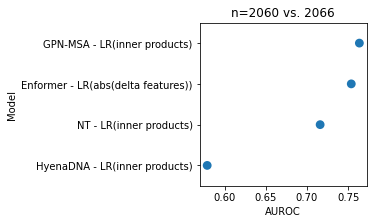

In [24]:
plt.figure(figsize=(3,3))
sns.pointplot(
    #data=results.replace({
    #    "Enformer_l2": "Enformer",
    #    "GPN-MSA": "GPN-MSA (LLR)",
    #}).query(
    #    "Model != 'NT' and Model != 'phastCons-100-vertebrates' and Model != 'HyenaDNA'"
    #),
    data=results[results.Model.str.contains("LR")].replace("Enformer - LR(inner products)", "Enformer - LR(abs(delta features))"),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);

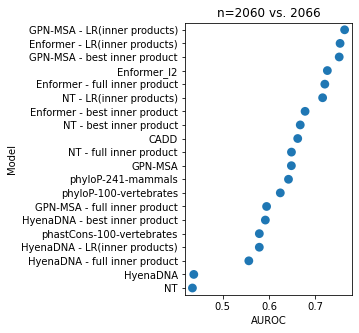

In [26]:
plt.figure(figsize=(3,5))
sns.pointplot(
    #data=results.replace({
    #    "Enformer_l2": "Enformer",
    #    "GPN-MSA": "GPN-MSA (LLR)",
    #}).query(
    #    "Model != 'NT' and Model != 'phastCons-100-vertebrates' and Model != 'HyenaDNA'"
    #),
    data=results,
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);